# Chapter 4
## Numerical Solution of the Hodgkin-Huxley ODEs

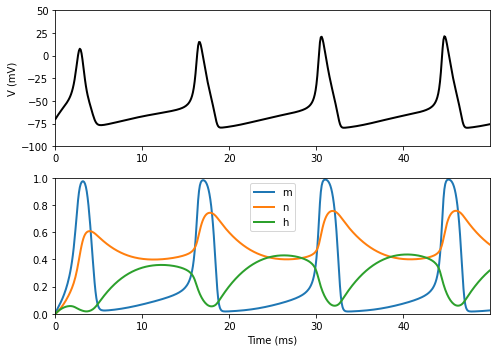

In [7]:
from brian2 import *
import pylab as plot

num_neurons = 1
duration = 50*msecond

# Parameters
area = 80000*umetre**2
Cm = 1*ufarad*cm**-2 * area

El = -59*mV
EK = -82*mV
ENa = 45*mV

gl = 0.3*msiemens*cm**-2 * area
g_na = 120*msiemens*cm**-2 * area
g_k = 36*msiemens*cm**-2 * area

# The model
eqs = Equations('''
beta_n = 0.125 * exp(-(v + 70.0*mV) / (80.0*mV))/ms: Hz
beta_m = 4.0 * exp(-(v + 70.0*mV) / (18.0*mV))/ms: Hz
beta_h = 1. / (exp(-(v + 40.0*mV) / (10.0*mV)) + 1.0)/ms : Hz
alpha_n = 0.01/mV * (-60.0*mV - v) / (exp((-60.0*mV - v) / (10.0*mV)) - 1.0)/ms: Hz
alpha_m = (v + 45.0*mV) / (10.0*mV) / (1.0 - exp(-(v + 45.0*mV) / (10.0*mV)))/ms : Hz
alpha_h = 0.07*exp(-(v + 70*mV) / (20*mV))/ms : Hz
dv/dt = (-gl*(v-El) - g_na*(m*m*m)*h*(v-ENa) - g_k*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = alpha_m * (1.0 - m) - beta_m * m : 1
dn/dt = alpha_n * (1.0 - n) - beta_n * n : 1
dh/dt = alpha_h * (1.0 - h) - beta_h * h : 1
I : amp
''')

# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,
                    # threshold='v > -40*mV',
                    refractory='2*ms',
                    threshold='v>-55*mV',
                    method='exponential_euler')
group.v = -70.0 *mV
group.I = '10 *nA'

monitor = SpikeMonitor(group)
M = StateMonitor(group, ["v", "n", "m", "h"], record=True)

run(duration)

fig, ax = plt.subplots(2, figsize=(7, 5))

ax[1].set_xlabel('Time (ms)')
ax[0].set_ylabel('V (mV)')
ax[0].plot(M.t / ms, M.v[0] / mV, lw=2, c='k')
ax[1].plot(M.t/ms, M.m[0], lw=2, label='m')
ax[1].plot(M.t/ms, M.n[0], lw=2, label='n')
ax[1].plot(M.t/ms, M.h[0], lw=2, label='h')

ax[0].margins(x=0)
ax[1].margins(x=0)
ax[0].set_ylim(-100, 50)
ax[1].set_ylim([0, 1])
ax[1].legend()
plt.tight_layout()
plt.show();